# STAREPandas Multiprocessing

In [1]:
import dask
import numpy
import starepandas
import geopandas
import pystare
import pandas
import matplotlib.pyplot as plt
import datetime
import time

In [2]:
us = geopandas.read_file('../tests/data/tl_2017_us_state.gpkg')
us = us.to_crs('EPSG:4326')
len(us)

56

In [3]:
us.head()
us = us[0:6]

## Parallel SID lookup

In [4]:
def sids_from_geoseries(series, level, convex=False, force_ccw=True, n_workers=1):
    sids = []
    for geom in series:
        sids_row = starepandas.sids_from_shapely(geom=geom, level=level, convex=convex, force_ccw=force_ccw)
        sids.append(sids_row)
    sids = numpy.array(sids, dtype='object')  # Has to be object to suppress VisibleDeprecationWarning
    return sids

In [5]:
n_workers = 2

ddf = dask.dataframe.from_pandas(us.geometry, npartitions=n_workers)
meta = {'sids': 'uint64'}

res = ddf.map_partitions(lambda df: numpy.array(sids_from_geoseries(df, level=7, convex=False, force_ccw=False, n_workers=1), dtype='object'), 
                         meta=meta)

sids = res.compute(scheduler='processes')

### High level

In [6]:
stare = starepandas.sids_from_geoseries(us.geometry, 
                                        level=7, 
                                        convex=False, 
                                        force_ccw=True, 
                                        n_partitions=4)

# Parallel Trixel lookup

## Manual / low level

In [7]:
n_cores = 4

us['stare'] = stare
ddf = dask.dataframe.from_pandas(us['stare'], npartitions=n_cores)
meta = {'trixels': 'object'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.trixels_from_stareseries(df)), meta=meta)
trixels = res.compute(scheduler='processes')

## High level

In [8]:
stare = pandas.Series(stare)
trixels = starepandas.trixels_from_stareseries(stare, n_partitions=4)

# Parallel instantiation

In [9]:
us = starepandas.STAREDataFrame(us, 
                                add_sids=True, 
                                level=7, 
                                add_trixels=True, 
                                n_partitions=4)

<AxesSubplot:>

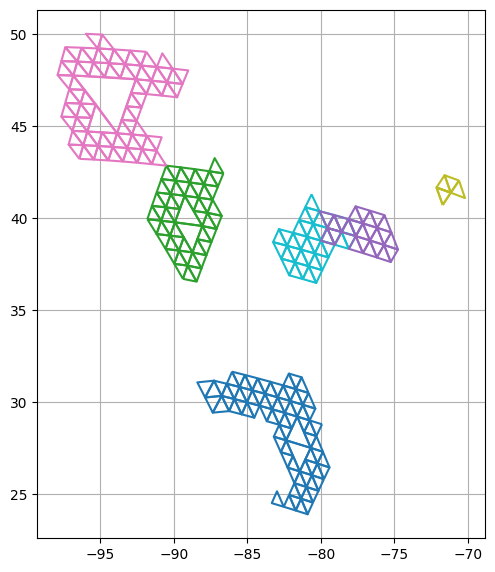

In [10]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
ax.grid(True)

us.plot(ax=ax, trixels=True, column='NAME')

# Visualization

In [11]:
us

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stare,sids,trixels
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...","[3137320090416971783, 3137355274789060615, 313...","[3137320090416971783, 3137355274789060615, 313...","MULTIPOLYGON (((-79.56820 39.46980, -79.99541 ..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ...","[3119129770047045639, 3119446429395845126, 312...","[3119129770047045639, 3119446429395845126, 312...","MULTIPOLYGON (((-82.52250 24.32624, -82.98181 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...","[3072299370796810246, 3072440108285165574, 307...","[3072299370796810246, 3072440108285165574, 307...","MULTIPOLYGON (((-88.73033 38.14162, -88.05766 ..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...","[3077084445400891397, 3077647395354312710, 307...","[3077084445400891397, 3077647395354312710, 307...","MULTIPOLYGON (((-92.56837 47.54242, -96.82683 ..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...","[3137320090416971783, 3164341688181194759, 316...","[3137320090416971783, 3164341688181194759, 316...","MULTIPOLYGON (((-79.56820 39.46980, -79.99541 ..."
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,2677997539,1323452846,+41.5974187,-071.5272723,"MULTIPOLYGON (((-71.67881 41.15891, -71.67626 ...","[3163708369483595783, 3163391710134796295, 316...","[3163708369483595783, 3163391710134796295, 316...","MULTIPOLYGON (((-71.71678 40.71857, -71.16875 ..."


,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stare,sids,trixels
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...","[3137320090416971783, 3164341688181194759, 316...","[3137320090416971783, 3164341688181194759, 316...","MULTIPOLYGON (((-79.56820 39.46980, -79.99541 ..."


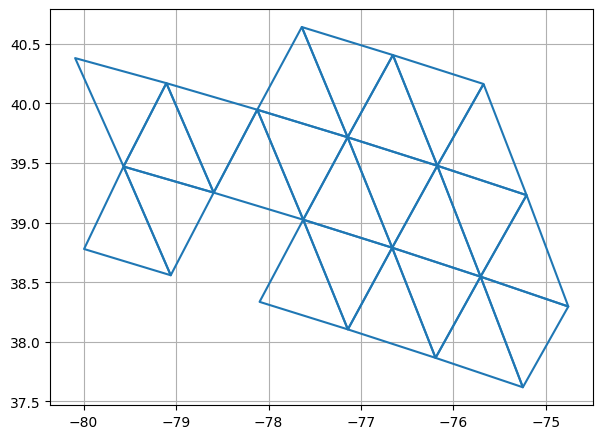

In [12]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
ax.grid(True)

hawaii = us[us['NAME']=='Maryland']
hawaii.plot(ax=ax, trixels=True)
hawaii

# Parallel dissolve

In [13]:
us_regions = us.stare_dissolve(by='REGION', aggfunc='sum', num_workers=4, geom=False)

In [14]:
trixels = us_regions.make_trixels(n_partitions=4)
us_regions.set_trixels(trixels, inplace=True)

<AxesSubplot:>

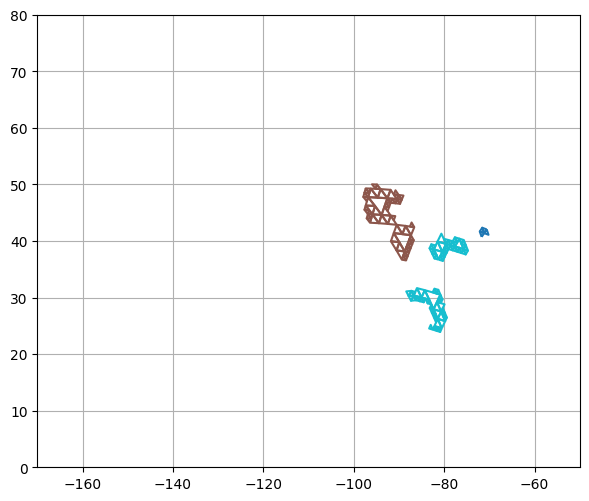

In [15]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
ax.grid(True)

ax.set_xlim(-170, -50)
ax.set_ylim(0, 80)

us_regions.reset_index().plot(ax=ax, trixels=True, column='REGION')

# Parallel Intersects

## Cover

In [16]:
us = starepandas.STAREDataFrame(us, add_sids=True, 
                                level=6, add_trixels=True, n_partitions=4)

In [17]:
filepath = '../tests/data/granules/VNP03DNB.A2020219.0742.001.2020219124651.nc'
vnp03 = starepandas.io.granules.VNP03DNB(filepath)
vnp03.read_sidecar_cover()
vnp03_cover = vnp03.stare_cover
vnp03_cover_df = starepandas.STAREDataFrame({'stare': vnp03.stare_cover}, sids='stare', add_trixels=True)

<AxesSubplot:>

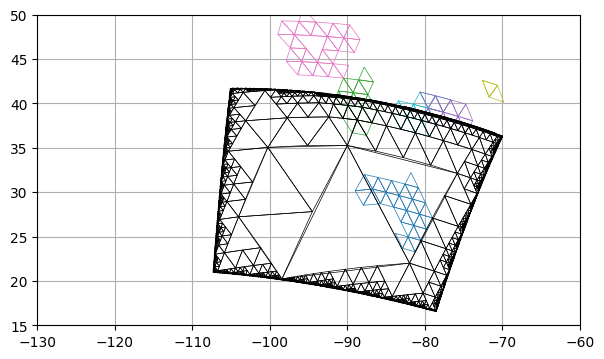

In [18]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
ax.grid(True)

ax.set_xlim(-130, -60)
ax.set_ylim(15, 50)

us.plot(ax=ax, column='NAME', trixels=True, linewidth=0.5)
vnp03_cover_df.plot(ax=ax, trixels=True, color='k', linewidth=0.5)

In [19]:
def series_intersects(other, series, method=1, n_workers=1):
    """ 
    Returns a bool series of length len(series).
    True for every row in which row intersects other.    
    """
    other = numpy.array([other]).flatten()
    
    if n_workers > len(series):
        # Cannot have more partitions than rows        
        n_workers = len(series) 
        
    if n_workers == 1:        
        if series.dtype in [numpy.dtype('uint64'), numpy.dtype('int64'), pandas.UInt64Dtype(), pandas.Int64Dtype()]:               
            # We have a series of sids; don't need to iterate. Can send the whole array to pystare/
            intersects = pystare.intersects(other, series, method)
        else:
            intersects = []   
            for sids in series:        
                if len(list(sids)) < len(other):
                    # If we do method 1, larger item first is faster
                    intersects.append(pystare.intersects(other, sids, method).any())
                else:
                    intersects.append(pystare.intersects(sids, other, method).any())
            intersects = numpy.array(intersects)
    else:
        ddf = dask.dataframe.from_pandas(series, npartitions=n_workers)
        meta = {'intersects': 'bool'}
        res = ddf.map_partitions(lambda df: series_intersects(other, df, method, 1), meta=meta)
        intersects = res.compute(scheduler='processes')    
    return intersects

In [20]:
a = numpy.array(vnp03_cover)

In [21]:
start = datetime.datetime.now()
intersects = series_intersects(a, us['stare'] , 1, 1)
print(datetime.datetime.now() - start)

0:00:00.001699


In [22]:
start = datetime.datetime.now()
intersects = series_intersects(a, us['stare'], 1, 5)
print(datetime.datetime.now() - start)

0:00:00.699152


In [23]:
intersects

array([ True,  True,  True, False,  True, False])

In [24]:
print(list(us[intersects]['NAME']))

['West Virginia', 'Florida', 'Illinois', 'Maryland']


## iFOVs

In [25]:
import copy
filepath = '../tests/data/granules/VNP03DNB.A2020219.0742.001.2020219124651.nc'
vnp03 = starepandas.read_granule(filepath, sidecar=True, xy=True)
vnp03 = copy.copy(vnp03[vnp03.y>1500])

In [26]:
state_sids = us[us['NAME']=='Florida']['stare'].iloc[0]

In [27]:
start = datetime.datetime.now()
intersects = series_intersects(state_sids, vnp03['sids'])
print(datetime.datetime.now() - start)

0:00:09.251401


In [28]:
start = datetime.datetime.now()
intersects = series_intersects(state_sids, vnp03['sids'], 1, 60)
print(datetime.datetime.now() - start)

0:00:06.608146


In [29]:
intersects.sum()/vnp03.index.size

0.04182729704280899

In [30]:
vnp03[intersects]

,sids,x,y,moon_illumination_fraction,land_water_mask,quality_flag
6102337,3397086378837675182,2273,1501,92.849998,0,0
6102338,3397086381026421070,2274,1501,92.849998,0,0
6102339,3397086404710208846,2275,1501,92.849998,0,0
6102340,3397086415242594286,2276,1501,92.849998,0,0
6102341,3397086441098915054,2277,1501,92.849998,0,0
...,...,...,...,...,...,...
9058015,3118997947546240654,3423,2228,92.879997,7,0
9058016,3118997851493397806,3424,2228,92.879997,7,0
9058017,3118997861386527694,3425,2228,92.879997,7,0
9058018,3118997831926651342,3426,2228,92.879997,7,0


## High level

In [31]:
intersects = vnp03.stare_intersects(other=state_sids, method=1, n_partitions=4)

In [32]:
vnp03.info()

<class 'starepandas.staredataframe.STAREDataFrame'>
Int64Index: 7034784 entries, 6100064 to 13134847
Data columns (total 6 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   sids                        Int64  
 1   x                           uint16 
 2   y                           uint16 
 3   moon_illumination_fraction  float32
 4   land_water_mask             UInt8  
 5   quality_flag                UInt8  
dtypes: Int64(1), UInt8(2), float32(1), uint16(2)
memory usage: 194.6 MB
